Osnabrück University - Computer Vision (Winter Term 2024/25) - Dr. Ulf Krumnack, Lukas Niehaus, Robin Rawiel

# Exercise Sheet 04: Color and segmentation

## Introduction

This week's sheet should be solved and handed in before the end of **Monay, December 9th, 2024**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Assignment 0: Math recap (the exponential function) [0 Points]

This exercise is supposed to be basic (but maybe less familiar than the last one), does not give any points, and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up (again). You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What is an *exponential function*? How can it be characterized? What is special about $e^x$?

YOUR ANSWER HERE

**b)** How is the exponential function defined for complex arguments? In what way(s) does this generalize the real case?

YOUR ANSWER HERE

**c)** The complex exponential function allows to define a mapping $\mathbb{R}\to\mathbb{C}$ by $x\mapsto e^{ix}$? How does the graph of this mapping look like? Where are the points $e^{2\pi i\frac mn}$ for $m=0,...,n\in\mathbb{N}$ located on this graph?

YOUR ANSWER HERE

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## Assignment 1: Implementation: Skeletonization (5 points)

### a) Skeletonization with hit-or-miss

Explain in your own words, how the hit-or-miss operator can be used for skeletonization (cf CV-05 slide 39).  

The hit-or-miss operator in skeletonization systematically removes non-skeleton pixels by matching specific boundary patterns with structuring elements. This process extracts the essential structure of an object, making it useful for applications requiring compact and meaningful shape representations.

***How Hit-or-Miss Operator Facilitates Skeletonization***

**Structuring Elements:**

Small binary matrices represent specific patterns (e.g., vertical, horizontal, diagonal edges).
These elements detect boundary pixels for removal in different orientations (left, right, up, down, and diagonals).
Iterative Process:

**At each iteration:**

The hit-or-miss operator applies a structuring element to detect boundary pixels in a specific direction.
These boundary pixels are removed if they are not part of the skeleton.
The process continues until no further boundary pixels can be removed.

**Skeleton Properties:**

Ridges in the distance transform of the shape correspond to the skeleton.
These ridges are points where bi-tangent circles (circles touching the boundary at exactly two points) exist.

**Directions for Hit-or-Miss:**

The operator applies eight directional structuring elements to handle all possible orientations:

Horizontal: Left (𝑆_𝑙 ), Right (𝑆_r).
Vertical: Up (𝑆_u ), Down (𝑆_d).
Diagonals: Top-left (𝑆_𝑙𝑢 ), Top-right (𝑆_𝑟𝑢), Bottom-left (𝑆_𝑙𝑑), Bottom-right (𝑆_𝑟𝑑).

### b) Implementation of skeletonization

Now use this method to implement your own skeletonization function. It is ok to use
`scipy.ndimage.morphology.binary_hit_or_miss` here (but of course *not* `skimage.morphology.skeletonize` or similar functions). Compare your result with (CV-05 slide 40). Note that computing the skeleton using this method may take some time ...

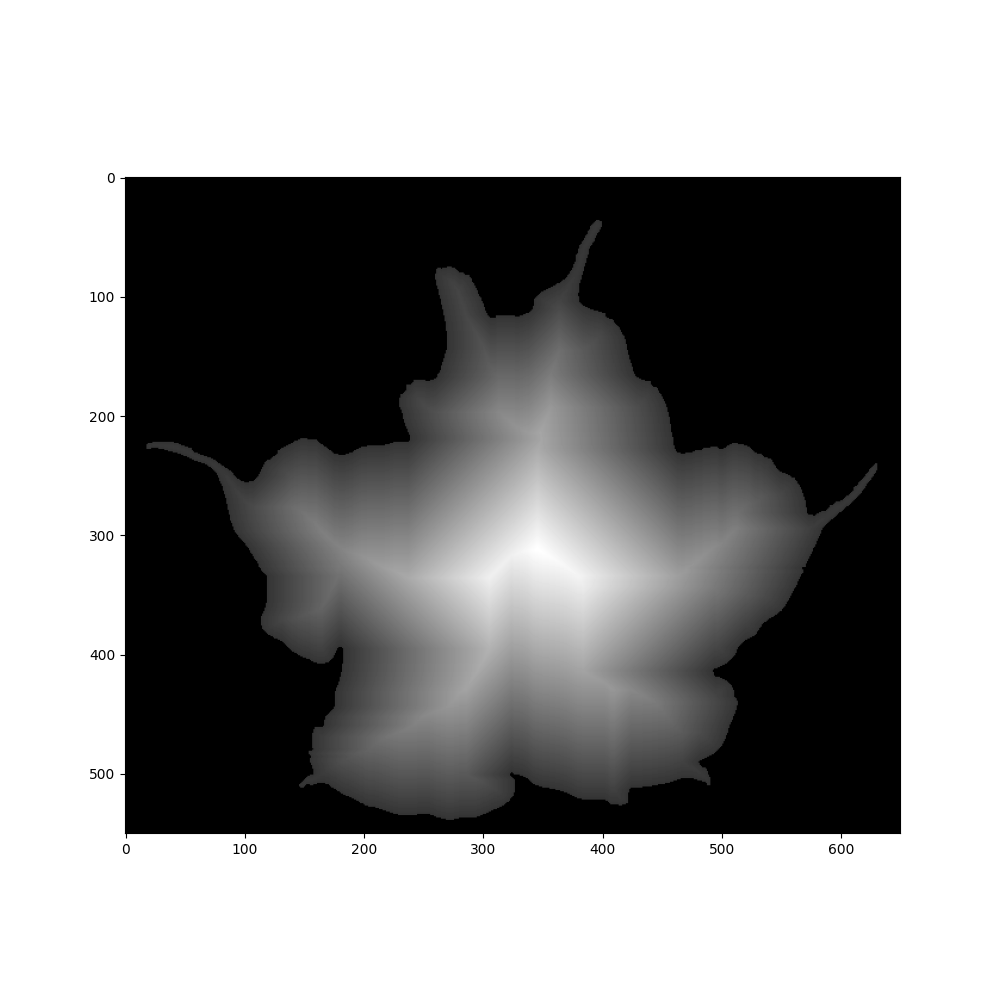

In [1]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_hit_or_miss, distance_transform_cdt, binary_dilation
from imageio.v3 import imread

def my_skeletonize(img):
    """
    Compute the skeleton of a binary image using hit_or_miss operator.
    
    Parameters
    ----------
    img : ndarray of bools
        Binary image to be skeletonized.
    
    Returns
    -------
    skeleton : ndarray of bools
        The skeleton of the input image.
    """
    # Define structuring elements for eight directions
    structuring_elements = [
        np.array([[0, 0, 0], [0, 1, 0], [1, 1, 1]]),  # Up
        np.array([[1, 1, 1], [0, 1, 0], [0, 0, 0]]),  # Down
        np.array([[0, 1, 0], [0, 1, 0], [0, 1, 0]]),  # Left
        np.array([[0, 1, 0], [0, 1, 0], [0, 1, 0]]),  # Right
        np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]]),  # Top-left
        np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]),  # Bottom-right
        np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]]),  # Top-right
        np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]),  # Bottom-left
    ]
    
    # Initialize the skeleton as an empty array
    skeleton = np.zeros_like(img, dtype=bool)
    
    # Iteratively apply the hit-or-miss operation
    temp_img = img.copy()
    while True:
        # Apply hit-or-miss for all directions and combine results
        hit_or_miss_result = np.zeros_like(img, dtype=bool)
        for se in structuring_elements:
            hit_or_miss_result |= binary_hit_or_miss(temp_img, structure1=se)
        
        # Add the hit-or-miss result to the skeleton
        skeleton |= hit_or_miss_result
        
        # Subtract the hit-or-miss result from the original image
        new_img = temp_img & ~hit_or_miss_result
        
        # Break if no more changes occur
        if np.array_equal(new_img, temp_img):
            break
        
        temp_img = new_img
    
    return skeleton


# Load binary image and compute skeleton
img = imread("/Users/positive-expectations/Downloads/images-2/engelstrompete.png") > 0
skel = my_skeletonize(img)

# Create a visualization result
result = distance_transform_cdt(img, metric='taxicab') + (50 * img)
result[binary_dilation(skel)] = 0

# Display the result
plt.figure(figsize=(10, 10))
plt.gray()
plt.imshow(result)
plt.show()


## Assignment 2: Hough transform (5 points)

**a)** Explain in your own words the idea of Hough transform in general. What is an accumulator space? In what sense can the Hough transform be seen as a model-based approach?

**Answer**
The Hough Transform is a technique in computer vision for detecting shapes (e.g., lines, circles) in images. It works by transforming points in the image space into a parameter space, where potential shapes can be identified based on their parameter values.



Key Concepts:
Shape Detection:

Identifies shapes like lines, circles, or other curves by mapping image points to their potential parameters.
For example, a line in a 2D space can be represented in parameter space by its slope (𝑚) and intercept (𝑐), or in polar form by its distance (𝜌) and angle (𝜃).

Parameter Space:

The transform works by representing shapes in terms of their parameters, not their explicit equations in the image space.
For instance, each edge pixel in the image contributes to possible line parameters (𝜌,𝜃) in parameter space.


**What is an Accumulator Space?**
The accumulator space is a discrete grid used to store votes for possible parameter values corresponding to detected shapes.
Each edge pixel in the image "votes" for a range of parameters that could define a shape passing through that pixel.
Peaks in the accumulator space correspond to parameter values that are most likely to represent a valid shape in the image.

Hough Transform as a Model-Based Approach
Model-Based Nature:

The Hough Transform assumes a mathematical model for the shapes it seeks (e.g., lines, circles).
By parameterizing these models (e.g., 𝜌,𝜃 for lines), it searches for shapes consistent with the edge points.

Why Model-Based?:

Instead of directly searching for shapes in the image space (which can be computationally expensive), it leverages the model's parameterization to simplify the detection process. This reduces the problem to finding peaks in the accumulator space, which represent shapes matching the assumed model.

**b)** What is linear Hough transform? What does a point in the linear Hough space represent? Explain the meaning of the two coordinates.

**Definition** 

The linear Hough transform is a specific application of the Hough Transform used to detect straight lines in an image. It maps each point in the image space (typically an edge pixel) to all possible straight lines passing through it in the Hough parameter space.

Hough Parameter Space for Lines
A straight line can be represented using the polar form equation: ρ=xcosθ+ysinθ

ρ: The perpendicular distance from the origin to the line.

θ: The angle of the normal vector to the line, measured counterclockwise from the x-axis.
The Hough parameter space is defined by:  ρ (distance) and θ (angle).

Each edge pixel (x,y) in the image votes for a set of (ρ,θ) pairs that represent all possible lines passing through that pixel.

**What Does a Point in the Linear Hough Space Represent?**

A point (ρ,θ) in the linear Hough space corresponds to a specific line in the image space:

ρ: The line’s perpendicular distance from the origin.

θ: The orientation of the line with respect to the x-axis.

Example:
A point in image space (x,y):
Maps to a sinusoidal curve in Hough space, representing all possible lines passing through (x,y).

A point in Hough space (ρ,θ):
Maps to a unique line in the image space.

**Meaning of the Two Coordinates**

ρ: Represents the distance from the origin to the closest point on the line (perpendicular distance).
Helps define the line’s position in space.

θ: Represents the orientation of the line.
Helps define the line’s angle relative to the x-axis.

Interpretation
Intersecting curves in Hough space: When multiple points in the image space contribute to the same (ρ,θ), it forms a peak in the Hough accumulator. This indicates the presence of a line with those parameters in the image.

**c)**  How are points, lines, polygons transformed by linear Hough transform? What about parallel lines? Try different configurations using the functions `point`, `line`, `polygon` below. Use the function `skimage.transform.hough_line` to display these examples. 
<!-- You may use the code of Assignment 2 to check different configurations interactively. -->

**Transformation by Linear Hough Transform**

Points:

Each point in the image space maps to a sinusoidal curve in the Hough space.
The sinusoidal curve represents all possible lines (ρ,θ) that pass through that point.

Lines:

A straight line in the image space maps to a single point in the Hough space.
The coordinates of this point, (ρ,θ), define the line's distance from the origin (ρ) and its orientation (θ).

Polygons:

Each edge of a polygon behaves like a line and maps to a distinct point in the Hough space.
The polygon as a whole contributes multiple points, one for each edge.

**Parallel Lines**

Behavior in Hough Space:

Parallel lines have the same orientation (θ) but different distances from the origin (ρ).
In the Hough space, they appear as distinct points along the same θ axis but with varying ρ values.

Key Insight:

The separation of points along the ρ axis reflects the spacing between the parallel lines in the image space.

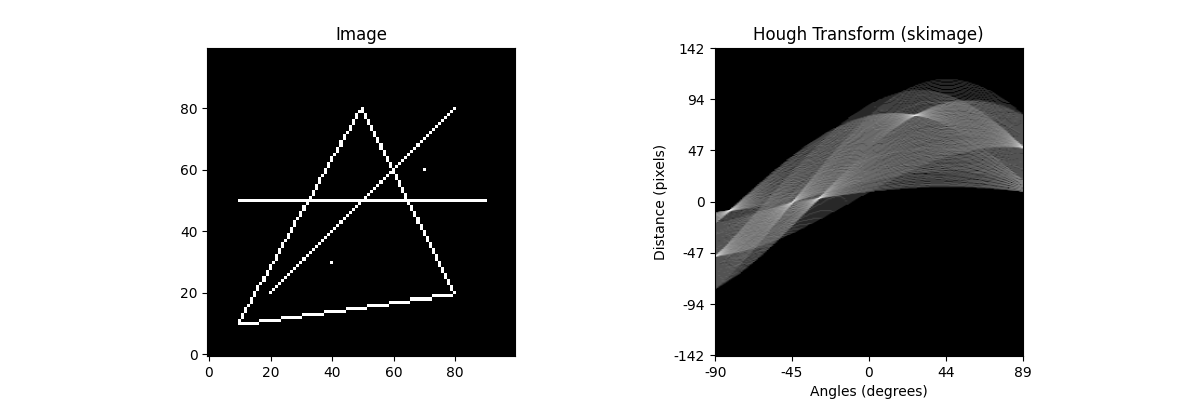

In [7]:
from skimage.transform import hough_line, resize 
#The hough_line function maps the image to its Hough parameter space (ρ,θ), detecting the presence of lines based on edge pixels.
import matplotlib.pyplot as plt
%matplotlib ipympl
import numpy as np

steps = lambda p, q: max(map(lambda x, y: abs(x - y), p, q)) + 1
coords = lambda p, q, s: tuple([np.linspace(x, y, s, dtype=np.uint16) for x, y in zip(p, q)])

def point(img, p):
    """Insert a point in the black/white image at position p"""
    img[p] = 1

def line(img, p, q):
    """Insert a line from p to q in the black/white image"""
    img[coords(p, q, steps(p, q))] = 1

def polygon(img, vertices):
    """Insert a (closed) polygon given by a list of points into the black/white image"""
    for p, q in zip(vertices, vertices[1:] + vertices[0:1]):
        line(img, p, q)

# Create an empty image
img = np.zeros((100, 100))

# Examples: Points, Lines, and Polygons
# 1. Add points to the image
point(img, (30, 40))
point(img, (60, 70))

# 2. Add lines to the image
line(img, (20, 20), (80, 80))  # Diagonal line
line(img, (50, 10), (50, 90))  # Vertical line

# 3. Add a polygon to the image
polygon(img, [(10, 10), (20, 80), (80, 50)])  # Triangle

# Plot the image and its Hough Transform
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4))

plt.gray()
ax1.set_title('Image')
ax1.imshow(img, origin='lower')

# Compute the Hough Transform
out, angles, d = hough_line(img)

# Resize output for better visualization
out_resized = resize(out, (out.shape[0], out.shape[0]), anti_aliasing=True, preserve_range=True)

ax2.set_title('Hough Transform (skimage)')
ax2.set_xlabel('Angles (degrees)')
ax2.set_ylabel('Distance (pixels)')
ax2.imshow(np.log(1 + out_resized), origin='lower', cmap='gray')

# Add axis ticks and labels
ax2.set_yticks(np.linspace(0, out.shape[0], 7))
ax2.set_yticklabels((-1 * np.linspace(d[-1], d[0], 7)).astype(int))
ax2.set_xticks(np.linspace(0, out.shape[0], 5))
ax2.set_xticklabels(np.linspace(np.rad2deg(angles[0]), np.rad2deg(angles[-1]), 5).astype(int))

plt.show()


**d)** The following code block implements an interactive Hough transform, in which you can either draw points or lines and can see the resulting Hough transform immediately. Draw different shapes of points or lines and check the resulting Hough transform. Try to predict the outcome of the transformation!

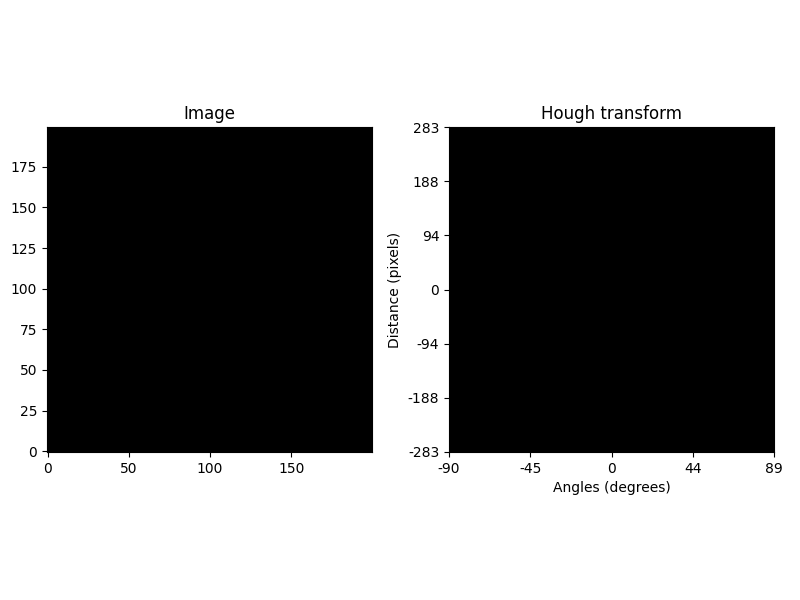

In [2]:
%matplotlib ipympl
from skimage.transform import hough_line, resize
import matplotlib.pyplot as plt
import numpy as np

# True if two mouse clicks should draw a line, false if single clicks draw points
lines = True

steps = lambda p,q : max(map(lambda x,y: abs(x-y), p, q))+1
coords = lambda p,q,s : tuple([np.linspace(x,y,s,dtype=np.uint16) for x,y in zip(p,q)])
img = np.zeros((200,200))

def line(img, p, q):
    """Insert a line from p to q in the black/white image
    
    Args:
        img (ndarray): Input image.
        p (tuple): Coordinate of start position.
        q (tuple): Coordinate of end position.
    
    Returns:
    
    """
    img[coords(p,q,steps(p,q))] = 1
    

def disp_and_comp():
    """Computes Line Hough transform; displays image and result
    
    Args:
    
    Returns:
    
    """
    ax1.imshow(img, origin = 'lower', cmap='gray')
    
    out, angles, d = hough_line(img)
    
    out_resized = resize(out, (out.shape[0], out.shape[0]), anti_aliasing=True, preserve_range=True)
    ax2.imshow(np.log(1 + out_resized), origin = 'lower', cmap='gray')
    ax2.set_yticks(np.linspace(0, out.shape[0], 7))
    ax2.set_yticklabels((-1 * np.linspace(d[-1], d[0], 7)).astype(int))
    ax2.set_xticks(np.linspace(0, out.shape[0], 5))
    ax2.set_xticklabels(np.linspace(np.rad2deg(angles[0]), np.rad2deg(angles[-1]), 5).astype(int))
    
    fig.canvas.draw()

    
first_point = True
p1 = (0,0)

def on_press(event):
    """Draws either line or point and calls disp_and_comp
    
    Reacts to mouse clicks. Draws either point at mouse
    position and computes Hough transform or draws line
    between first and second mouse click and then computes
    hough transfom.
    
    Args:
        event (event): Mouseevent.
    
    Returns:
    
    """
    global p1, first_point
    y = int(event.xdata)
    x = int(event.ydata)
    
    if (lines):
        if (first_point):
            p1 = (x,y)
            img[x, y] = 255  # Mark the first point
            first_point = False
        else:
            line(img, p1, (x, y))  # Draw line between the points
            first_point = True  # Reset for next line drawing
        disp_and_comp()
    else:
        img[x, y] = 255  # Mark a point for point-based Hough transform
        disp_and_comp()   

fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(121)
plt.title('Image')

ax2 = fig.add_subplot(122)
plt.title('Hough transform')
plt.xlabel('Angles (degrees)')
plt.ylabel('Distance (pixels)')
plt.tight_layout()
plt.axis('square')

disp_and_comp()
cnc = fig.canvas.mpl_connect('button_press_event', on_press)

# Optionally, allow clearing the image using a key event (for testing)
def on_key(event):
    """Clears the image when 'c' key is pressed."""
    global img
    if event.key == 'c':
        img = np.zeros((200,200))  # Clear the image
        disp_and_comp()

fig.canvas.mpl_connect('key_press_event', on_key)

plt.show()


## Assignment 3: Implementing Hough transform (5 points)

In [3]:
# Auxiliary functions for this exercise
import numpy as np
from skimage.transform import hough_line, resize

steps = lambda p,q : max(map(lambda x,y: abs(x-y), p, q))+1
coords = lambda p,q,s : tuple([np.linspace(x,y,s,dtype=np.uint16) for x,y in zip(p,q)])

def point(img, p):
    """Insert a point in the black/white image at position p
    
    Args:
        img (ndarray): Input image.
        p (tuple): Coordinate of point.
    
    Returns:
    
    """
    img[p] = 1

def line(img, p, q):
    """Insert a line from p to q in the black/white image
    
    Args:
        img (ndarray): Input image.
        p (tuple): Coordinate of start position.
        q (tuple): Coordinate of end position.
    
    Returns:
    
    """
    img[coords(p,q,steps(p,q))] = 1

def polygon(img, vertices):
    """Insert a (closed) polygon given by a list of points into the black/white image
    
    Args:
        img (ndarray): Input image.
        vertices (list): List of coordinate tuples.
    
    Returns:
    
    """
    for p, q in zip(vertices, vertices[1:]+vertices[0:1]):
        line(img,p,q)

**a)** Implement your own version of linear Hough transform and compare the results with the function `skimage.transform.hough_line`.

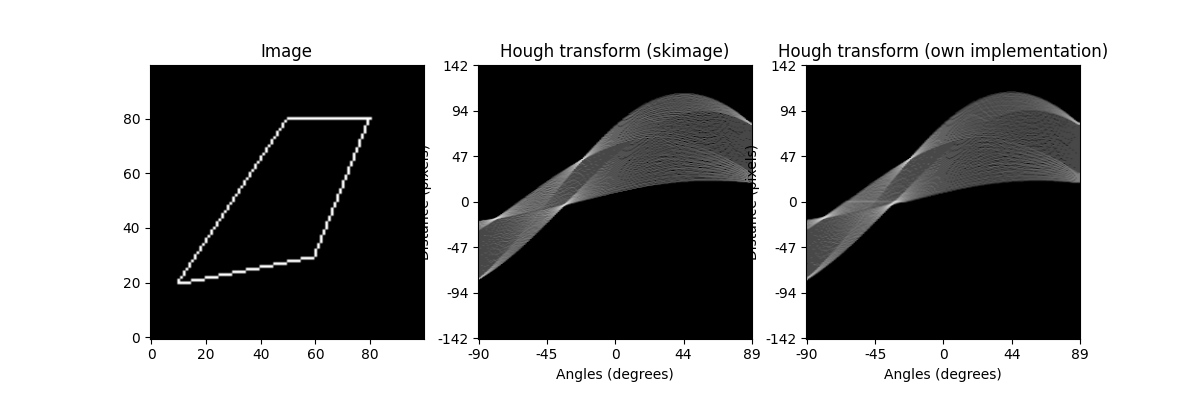

In [4]:
from skimage.transform import hough_line
import matplotlib.pyplot as plt
import numpy as np
import warnings
from skimage.draw import polygon
from skimage.transform import resize

warnings.filterwarnings('ignore')

# Function to perform the custom Hough transform
def my_hough_line(img, angles=180):
    """
    Apply linear Hough transform to the given image.
    
    Args:
        img (numpy.ndarray): The binary image to transform
        angles (int): The number of angles to consider (default 180).
    
    Returns:
        accumulator (numpy.ndarray): The accumulator space where each cell stores
                                      the number of votes for a particular (r, theta).
    """
    # Create a grid of (x, y) coordinates corresponding to the non-zero pixels in the image
    y, x = np.nonzero(img)  # Get coordinates of edge pixels

    # Define the angle range for the Hough transform
    angle_range = np.linspace(-np.pi / 2, np.pi / 2, angles)  # Angle range from -90° to 90°
    
    # Calculate the maximum possible distance (r_max) for r
    r_max = int(np.sqrt(img.shape[0]**2 + img.shape[1]**2))
    
    # Initialize the accumulator array (r, theta)
    accumulator = np.zeros((2 * r_max, angles), dtype=int)  # Use dtype=int instead of np.int
    
    # Iterate over each edge point (x, y)
    for i in range(len(x)):
        for j, angle in enumerate(angle_range):
            r = int(x[i] * np.cos(angle) + y[i] * np.sin(angle))  # Calculate r for each angle
            r_index = r + r_max  # Shift r to ensure it's always positive (centered around zero)
            accumulator[r_index, j] += 1  # Increment the accumulator at (r, theta)
    
    return accumulator

# Auxiliary functions for creating shapes in the image
steps = lambda p,q : max(map(lambda x,y: abs(x-y), p, q))+1
coords = lambda p,q,s : tuple([np.linspace(x,y,s,dtype=np.uint16) for x,y in zip(p,q)])

def point(img, p):
    """Insert a point in the black/white image at position p"""
    img[p] = 1

def line(img, p, q):
    """Insert a line from p to q in the black/white image"""
    img[coords(p, q, steps(p, q))] = 1

def polygon(img, vertices):
    """Insert a (closed) polygon given by a list of points into the black/white image"""
    for p, q in zip(vertices, vertices[1:]+vertices[0:1]):
        line(img, p, q)

# Test image with shapes
img = np.zeros((100, 100))

# Example shapes (polygon in this case)
polygon(img, [(20, 10), (80, 50), (80, 80), (30, 60)])

# Create subplots for comparison
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 4))
plt.gray()

# Original image
ax1.set_title('Image')
ax1.imshow(img, origin='lower')

# Hough transform using skimage
out, angles, d = hough_line(img)
out_resized = resize(out, (out.shape[0], out.shape[0]), anti_aliasing=True, preserve_range=True)
ax2.set_title('Hough transform (skimage)')
ax2.set_xlabel('Angles (degrees)')
ax2.set_ylabel('Distance (pixels)')
ax2.imshow(np.log(1 + out_resized), origin='lower', cmap='gray')
ax2.set_yticks(np.linspace(0, out.shape[0], 7))
ax2.set_yticklabels((-1 * np.linspace(d[-1], d[0], 7)).astype(int))
ax2.set_xticks(np.linspace(0, out.shape[0], 5))
ax2.set_xticklabels(np.linspace(np.rad2deg(angles[0]), np.rad2deg(angles[-1]), 5).astype(int))

# Hough transform using our custom implementation
my_out = my_hough_line(img)
my_out_resized = resize(my_out, (out.shape[0], out.shape[0]), anti_aliasing=True, preserve_range=True)
ax3.set_title('Hough transform (own implementation)')
ax3.set_xlabel('Angles (degrees)')
ax3.set_ylabel('Distance (pixels)')
ax3.imshow(np.log(1 + my_out_resized), origin='lower', cmap='gray')
ax3.set_yticks(np.linspace(0, out.shape[0], 7))
ax3.set_yticklabels((-1 * np.linspace(d[-1], d[0], 7)).astype(int))
ax3.set_xticks(np.linspace(0, out.shape[0], 5))
ax3.set_xticklabels(np.linspace(np.rad2deg(angles[0]), np.rad2deg(angles[-1]), 5).astype(int))

plt.show()


**b)**  Under which conditions is (linear) Hough transform invertible? Try to implement an inverse linear Hough transform. 

You could create a line for each point in accumulator space by doing the following: Compute angle and distance of the line represented by the current point in accumulator space. Add the value of this point to all image pixels which belong to the corresponding line. Finally you could threshold the image. 

However, other solution are feasible, too.


The linear Hough transform is invertible under ideal conditions: complete and noise-free data, no overlapping lines, sufficient resolution, and strict linearity of features. In practice, discretization, noise, sparsity, and overlapping lines make exact inversion challenging, leading to approximate reconstructions instead of perfect recovery.

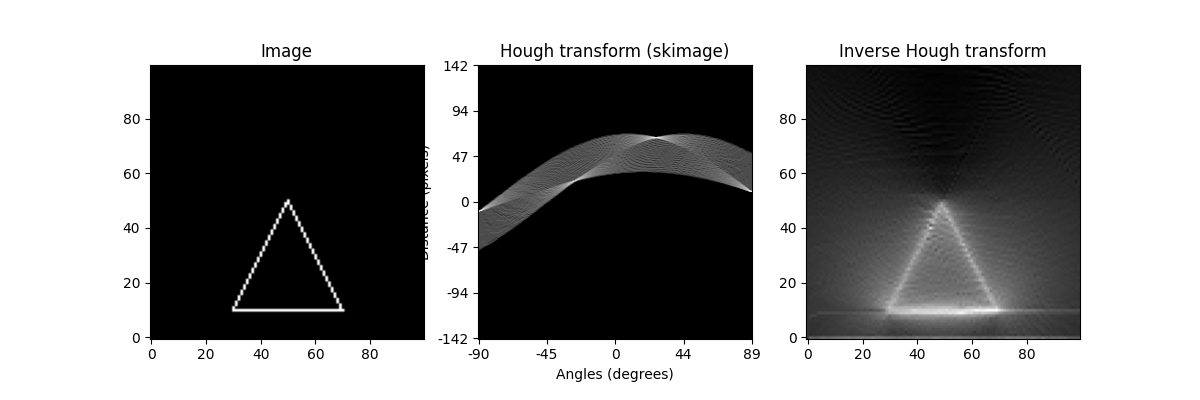

In [5]:
%matplotlib ipympl 
from skimage.transform import hough_line, resize
import matplotlib.pyplot as plt
import numpy as np

def my_inverse_hough_line(accumulator, shape):
    """Compute an inverse Hough transform, i.e. compute the image from the accumulator space.
    
    Args:
        accumulator (numpy.ndarray): The Hough accumulator space.
        shape (tuple): The shape (dimensions) of the image to be created.

    Returns:
        img (numpy.ndarray): The image created from the accumulator space.
    """
    # Initialize the reconstructed image
    img = np.zeros(shape, dtype=np.uint64)
    
    # Get the dimensions of the accumulator
    r_dim, theta_dim = accumulator.shape
    
    # Compute the range of angles and distances
    theta_range = np.linspace(-np.pi / 2, np.pi / 2, theta_dim)
    r_max = int(np.sqrt(shape[0]**2 + shape[1]**2))
    r_range = np.linspace(-r_max, r_max, r_dim)
    
    # Iterate over each peak in the accumulator
    for r_idx in range(r_dim):
        for theta_idx in range(theta_dim):
            # Check if the accumulator value is non-zero
            if accumulator[r_idx, theta_idx] > 0:
                r = r_range[r_idx]
                theta = theta_range[theta_idx]
                
                # Draw the corresponding line in the image
                for x in range(shape[1]):
                    if np.sin(theta) != 0:
                        y = int((r - x * np.cos(theta)) / np.sin(theta))
                        if 0 <= y < shape[0]:
                            img[y, x] += accumulator[r_idx, theta_idx]
    return img

# Create a test image
img = np.zeros((100, 100))
polygon(img, [(10, 30), (50, 50), (10, 70)])

# Display the original image
plt.figure(figsize=(12, 4))
plt.gray()
plt.subplot(1, 3, 1)
plt.title('Image')
plt.imshow(img, origin='lower')

# Compute the Hough transform using skimage
out, angles, d = hough_line(img)
out_resized = resize(out, (out.shape[0], out.shape[0]), anti_aliasing=True, preserve_range=True)

# Display the Hough transform
ax = plt.subplot(1, 3, 2)
ax.set_title('Hough transform (skimage)')
ax.set_xlabel('Angles (degrees)')
ax.set_ylabel('Distance (pixels)')
ax.imshow(np.log(1 + out_resized), origin='lower', cmap='gray')
ax.set_yticks(np.linspace(0, out.shape[0], 7))
ax.set_yticklabels((-1 * np.linspace(d[-1], d[0], 7)).astype(int))
ax.set_xticks(np.linspace(0, out.shape[0], 5))
ax.set_xticklabels(np.linspace(np.rad2deg(angles[0]), np.rad2deg(angles[-1]), 5).astype(int))

# Perform the inverse Hough transform
img2 = my_inverse_hough_line(out, img.shape)

# Display the reconstructed image
plt.subplot(1, 3, 3)
plt.title('Inverse Hough transform')
plt.imshow(img2, origin='lower')
plt.show()


## Assignment 4: Circular Hough (5 points)

**a)** Explain the idea of circular Hough transform. How many dimensions does the accumulator space have and what do they represent? What practical problems do you expect when computing circular Hough transform?

**Idea of Circular Hough Transform (CHT):**
The Circular Hough Transform is an extension of the Hough Transform used to detect circles in an image. Instead of parameterizing lines, it parameterizes circles using the general equation:

(x−a)2 + (y−b)2 = r2

Where: (a,b) are the coordinates of the circle's center. r is the radius of the circle.

The CHT works by mapping edge points in the image space to possible circle parameters in the accumulator space. Each edge point votes for all circles that could pass through it, and peaks in the accumulator correspond to detected circles.

Accumulator Space Dimensions:

The accumulator space has three dimensions, which represent:

a: x-coordinate of the circle's center.

b: y-coordinate of the circle's center.

r: Radius of the circle.

**Practical Problems in Computing CHT:**

*High Computational Cost:* The 3D accumulator space increases memory and computational requirements, especially for images with many edge points or a wide range of potential radii.

*Noise Sensitivity:* Noise or irrelevant edge points in the image can lead to spurious votes, producing false positives.

*Overlapping Circles:* When circles overlap or are close together, their votes may interfere, making it hard to distinguish between them.

*Radius Range:* Detecting circles of unknown radius requires searching across a wide range of r, further increasing computational cost.

*Edge Quality:* Poor edge detection (e.g., weak or broken edges) can lead to missed circles or inaccurate center and radius estimation.

*Quantization Errors:* Discretization of (a,b,r) can lead to inaccuracies, particularly for small or closely spaced circles.

In summary, while the Circular Hough Transform is powerful for detecting circles, it is computationally intensive and sensitive to noise and edge quality, with challenges in managing the 3D accumulator space and overlapping detections.



**b)** Now implement circular hough transform. First think how the accumulator space should be represented. You may provide an additional parameter to only look for circles of a given radius (or a range of radii). Then apply it to the image `xmas.png` to detect the balls. Mark them in the original image. (Bonus task: also detect the presents using linear Hough transform).

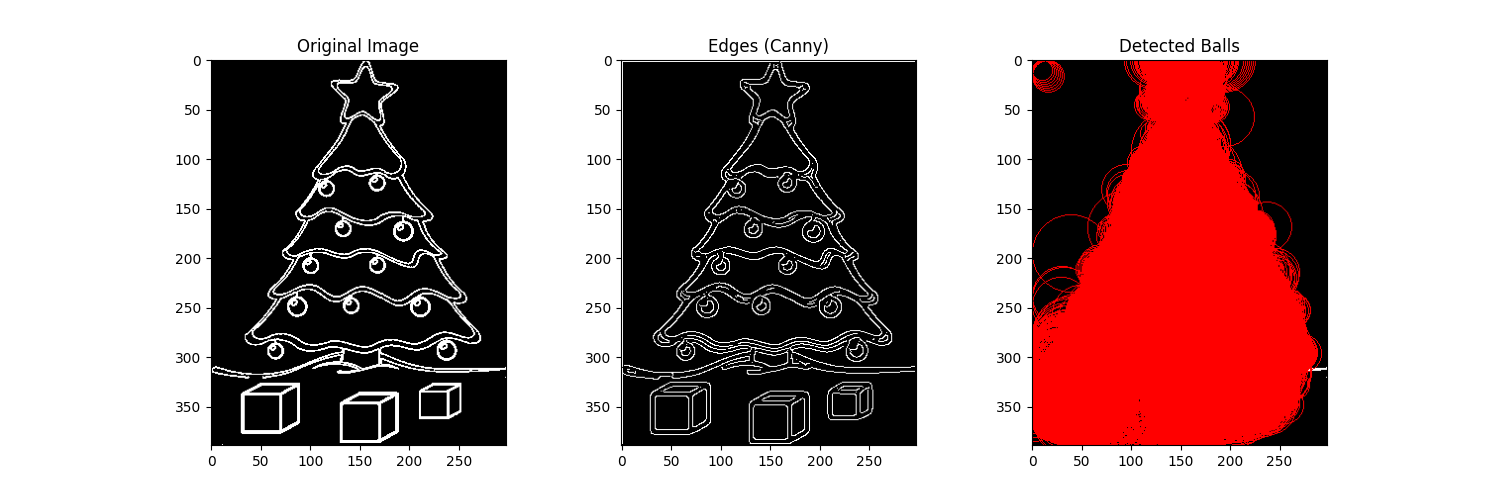

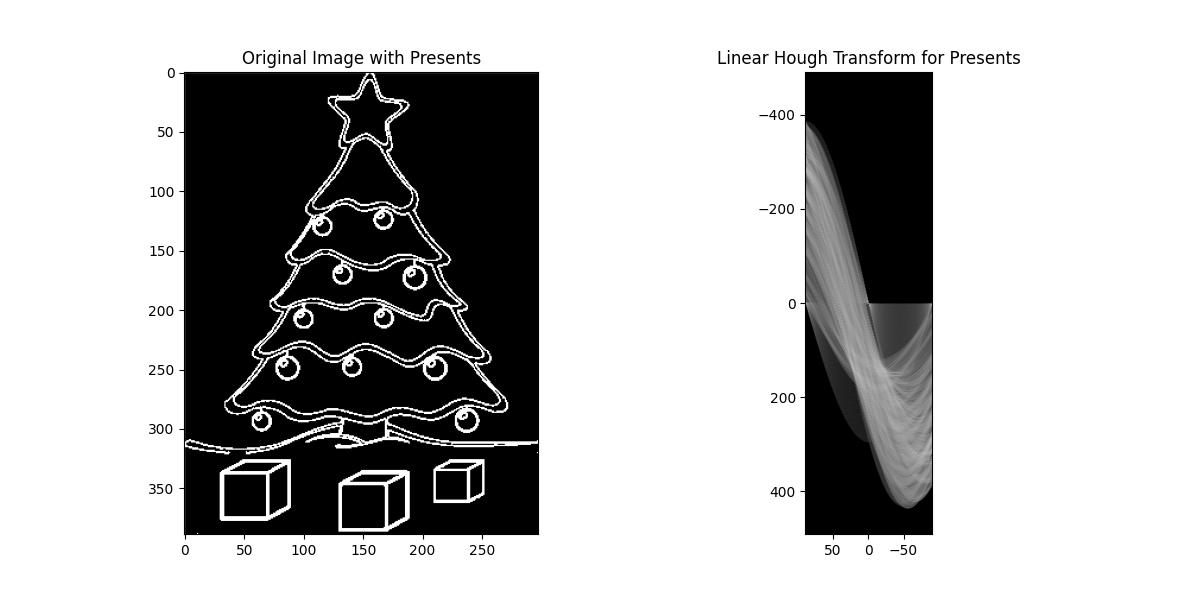

In [6]:
%matplotlib ipympl
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.color import gray2rgb
from skimage.transform import hough_line
from scipy import misc
from imageio.v3 import imread
import matplotlib.pyplot as plt
import numpy as np

def circular_hough_transform(img, radius_range):
    """
    Perform Circular Hough Transform to detect circles.
    
    Args:
        img (numpy.ndarray): Grayscale or binary edge-detected input image.
        radius_range (tuple): Range of radii to look for circles (min_radius, max_radius).
        
    Returns:
        accumulator (numpy.ndarray): Accumulator array of shape (height, width, radius).
        detected_circles (list): List of detected circles as [(a, b, r)].
    """
    min_radius, max_radius = radius_range
    height, width = img.shape
    radii = range(min_radius, max_radius + 1)
    
    # Initialize the accumulator space
    accumulator = np.zeros((height, width, len(radii)), dtype=np.uint64)
    edge_points = np.argwhere(img > 0)  # Get edge points (y, x)

    # Voting process
    for y, x in edge_points:
        for r_idx, r in enumerate(radii):
            for angle in np.linspace(0, 2 * np.pi, 100):  # 100 steps around the circle
                a = int(x - r * np.cos(angle))
                b = int(y - r * np.sin(angle))
                if 0 <= a < width and 0 <= b < height:
                    accumulator[b, a, r_idx] += 1

    # Detect local maxima in the accumulator
    threshold = np.percentile(accumulator, 99)  # Adjust threshold for sensitivity
    detected_circles = []
    for r_idx, r in enumerate(radii):
        circle_candidates = np.argwhere(accumulator[:, :, r_idx] > threshold)
        for b, a in circle_candidates:
            detected_circles.append((a, b, r))
    
    return accumulator, detected_circles

def mark_circles(image, circles):
    """
    Draw circles on the image.
    
    Args:
        image (numpy.ndarray): Original image in RGB.
        circles (list): List of detected circles as [(a, b, r)].
    
    Returns:
        numpy.ndarray: Image with circles marked.
    """
    img_with_circles = gray2rgb(image) if len(image.shape) == 2 else image.copy()
    for a, b, r in circles:
        rr, cc = circle_perimeter(b, a, r, shape=img_with_circles.shape[:2])
        img_with_circles[rr, cc] = (255, 0, 0)  # Mark with red color
    return img_with_circles

# Load the image and preprocess
img = imread('/Users/positive-expectations/Downloads/images-2/xmas.png', pilmode='L')  # Load grayscale image
edges = canny(img, sigma=2)  # Detect edges

# Detect circles
radius_range = (10, 50)  # Adjust based on the expected ball sizes
accumulator, detected_circles = circular_hough_transform(edges, radius_range)

# Mark detected circles on the original image
marked_img = mark_circles(img, detected_circles)

# Plot results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(edges, cmap='gray')
ax[1].set_title('Edges (Canny)')
ax[2].imshow(marked_img)
ax[2].set_title('Detected Balls')
plt.show()

# Bonus Task: Linear Hough Transform for presents
hough_accumulator, angles, distances = hough_line(edges)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image with Presents')
ax[1].imshow(np.log(1 + hough_accumulator), extent=[np.rad2deg(angles[-1]), np.rad2deg(angles[0]), distances[-1], distances[0]], cmap='gray', aspect=1/1.5)
ax[1].set_title('Linear Hough Transform for Presents')
plt.show()
